# Data processing and modeling

* Build the processsing pipeline:
    * Fill in missing values
    * Binarize precipitation variables
    * Scale numerical variables
* Fit a baseline model: linear regression
* Fit a random forest regression model:
    * Find optimal tree depth
    * Fit final model

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, StandardScaler
%matplotlib inline

## Load the data

In [2]:
# load the data
train = pd.read_csv('train.csv', index_col='Date',parse_dates=True)
test = pd.read_csv('test.csv', index_col='Date', parse_dates=True)

# get the target variable and predictors
y_train = train['Burrard_at_Cornwall']
y_test = test['Burrard_at_Cornwall']
X_train = train.drop(['Burrard_at_Cornwall'], axis=1)
X_test = test.drop(['Burrard_at_Cornwall'], axis=1)
X_train.head()

,month,day,wx_max_temp_c,wx_min_temp_c,wx_mean_temp_c,wx_total_rain_mm,wx_total_snow_cm,wx_total_precip_mm,wx_snow_on_grnd_cm,day_of_week,is_holiday
Date,,,,,,,,,,,
2019-01-01,1,1,5.3,0.8,3.1,0.0,0.0,0.0,0.0,1,True
2019-01-02,1,2,5.5,2.4,4.0,3.4,0.0,3.4,0.0,2,False
2019-01-03,1,3,9.5,4.5,7.0,54.8,0.0,54.8,0.0,3,False
2019-01-04,1,4,10.4,6.1,8.3,9.6,0.0,9.6,0.0,4,False
2019-01-05,1,5,8.7,5.3,7.0,3.2,0.0,3.2,0.0,5,False


## Set up the processing pipeline

In [3]:
# select columns with precipitation data
# - missing values will be replaced by zero
# - boolean variables will be created for each column
precip_cols = [colname for colname in X_train.columns if
               ('rain' in X_train[colname].name or
               'snow' in X_train[colname].name or
               'precip' in X_train[colname].name) and
               X_train[colname].dtype in ['int64', 'float64']]
print(precip_cols)

['wx_total_rain_mm', 'wx_total_snow_cm', 'wx_total_precip_mm', 'wx_snow_on_grnd_cm']


In [4]:
# select date columns that don't have missing values
pass_cols = ['month', 'day', 'day_of_week', 'is_holiday']

In [5]:
# select columns with other temperature data - missing values will be interpolated
temp_cols = [colname for colname in X_train.columns if 
                  colname not in precip_cols and
                  colname not in pass_cols and
                 X_train[colname].dtype in ['int64', 'float64']]
print(temp_cols)

['wx_max_temp_c', 'wx_min_temp_c', 'wx_mean_temp_c']


In [6]:
# create custom transformer that interpolates missing values using Pandas ffill and bfill
class InterpolateTransformer(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        result = (X.ffill() + X.bfill()) / 2
        return result

In [7]:
# preprocessing for precipitation data
precip_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('std_scaler', StandardScaler()),
    ])

precip_binarizer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('binarizer', Binarizer(threshold=0.0, copy=False)),
    ])

# preprocessing for temperature data
temp_transformer = Pipeline(steps=[
    ('interp', InterpolateTransformer()),
    ('std_scaler', StandardScaler()),
    ])

## Baseline model: linear regression
As the baseline model, I will fit a multiple linear regression with the precipitation, temperature, and date variables as features. 

In [8]:
# bundle preprocessing for all data
preprocessor = ColumnTransformer(transformers=[
        ('precip', precip_transformer, precip_cols),
        ('temp', temp_transformer, temp_cols)],
        remainder = 'passthrough')

# define model
model = linear_model.LinearRegression()

# bundle preprocessing and modeling steps in a pipeline
final_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)])

# perform preprocessing and fit model on training data
final_pipe.fit(X_train, y_train);

# make predictions and get mean absolute error
# training set
y_pred = final_pipe.predict(X_train)
ln_mae_train = mean_absolute_error(y_train, y_pred)
print('Linear regression MAE on training set: %d bikes per day' % ln_mae_train)
# test set
y_pred = final_pipe.predict(X_test)
ln_mae_test = mean_absolute_error(y_test, y_pred)
print('Linear regression MAE on test set: %d bikes per day' % ln_mae_test)

Linear regression MAE on training set: 592 bikes per day
Linear regression MAE on test set: 482 bikes per day


//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


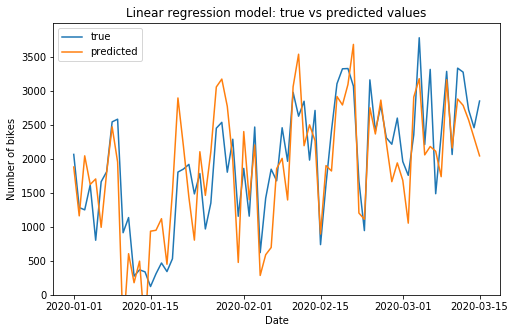

In [9]:
# create series with predicted values for plot
y_pred_df = pd.Series(y_pred, index=y_test.index, name=y_test.name)
y_pred_df.head()

# mean daily bike count in the test set
mean_y_test = y_test.mean()

# plot true and predicted values
fig, ax = plt.subplots(figsize=(8,5))
line_test = ax.plot(y_test, label='true')
line_pred = ax.plot(y_pred_df, label='predicted')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlabel('Date')
ax.set_ylabel('Number of bikes')
ax.set_title('Linear regression model: true vs predicted values');

The mean absolute error of the model is quite large: the predictions are off, on average, by 482 bikes per day. The graph shows that the model does capture the larger fluctuations in the data. I don't expect any of the models to perform great, because the training data set is very small. Let's see if we can get better performance with a slightly more advanced model.

#### Preprocessing

In [10]:
# bundle preprocessing, include binarizing of precipitation variables
preprocessor = ColumnTransformer(transformers=[
        ('precip', precip_transformer, precip_cols),
        ('precip_b', precip_binarizer, precip_cols),
        ('temp', temp_transformer, temp_cols)],
        remainder = 'passthrough')

# get variable names
precip_cols_bool = [colname.replace('_mm', '_bool').replace('_cm', '_bool') 
                    for colname in precip_cols]
rf_columns = precip_cols + precip_cols_bool + temp_cols + pass_cols

#### Find optimal tree depth using cross validation
I will estimate the optimal tree depth using k-fold cross-validation. This is not the best method for timeseries data like this. Ideally, one should use a method where the model is only validated forward in time, such as explained [here](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9). However, given the small size of the training set, I will split the data into three folds for 'regular' cross-validation.

In [11]:
def get_cv_score():
    """Return the average MAE over CV folds of random forest model.
    """
    
    # shuffle and split data
    cv = ShuffleSplit(n_splits=3, test_size=.33, random_state=0)

    # compute cross validation score 
    scores = -1 * cross_val_score(final_pipe, X_train, y_train, 
                                  cv=cv, scoring='neg_mean_absolute_error')
    
    return(scores.mean())

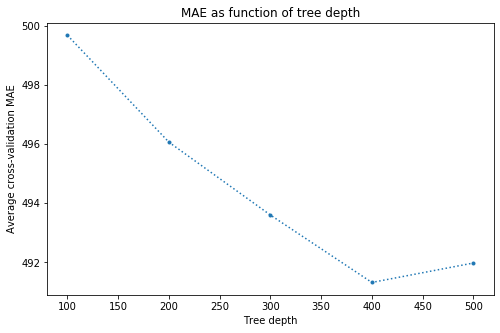

In [12]:
# find optimal tree depth
trees = range(100, 600, 100)
results = {}
for tree in trees:
    
    # bundle preprocessing and modeling code in a pipeline
    final_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=tree, random_state=0))])
    
    # compute cross-validation score
    results[tree] = get_cv_score()

# plot MAE as a function of tree depth
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(trees, list(results.values()), '.:')
ax.set_xlabel('Tree depth')
ax.set_ylabel('Average cross-validation MAE')
ax.set_title('MAE as function of tree depth');

#### Final model

In [13]:
# fit final model
trees = 400
final_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=trees, random_state=0))])
final_pipe.fit(X_train, y_train);

# make predictions and get mean absolute error
# training set
y_pred = final_pipe.predict(X_train)
rf_mae_train = mean_absolute_error(y_train, y_pred)
print('Random forest regression MAE on training set: %d bikes per day' % rf_mae_train)
# test set
y_pred = final_pipe.predict(X_test)
rf_mae_test = mean_absolute_error(y_test, y_pred)
print('Random forest regression MAE on test set: %d bikes per day' % rf_mae_test)

Random forest regression MAE on training set: 184 bikes per day
Random forest regression MAE on test set: 407 bikes per day


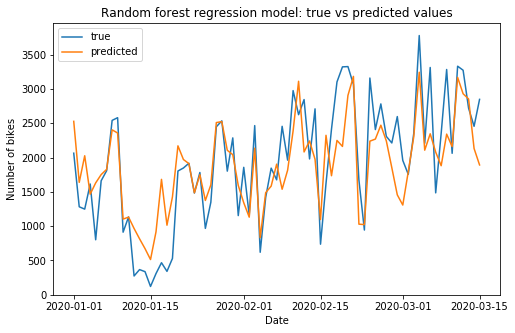

In [14]:
# create series with predicted values for plot
y_pred_df = pd.Series(y_pred, index=y_test.index, name=y_test.name)
y_pred_df.head()

# plot true and predicted values
fig, ax = plt.subplots(figsize=(8,5))
line_test = ax.plot(y_test, label='true')
line_pred = ax.plot(y_pred_df, label='predicted')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlabel('Date')
ax.set_ylabel('Number of bikes')
ax.set_title('Random forest regression model: true vs predicted values');

This model performs slightly better than the linear regression model: the mean absolute error  is 407 bikes per day. Let's take a look at which features are the most important predictors.

#### Feature importance

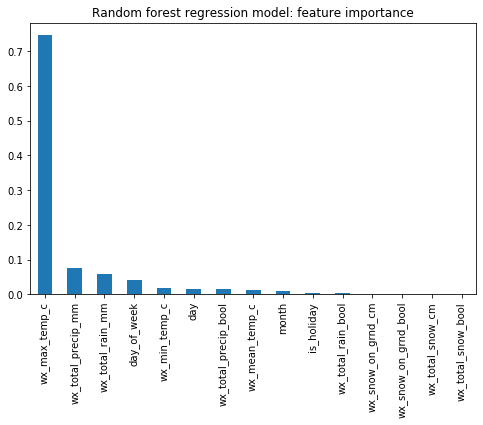

In [15]:
# get feature importances
importance = pd.DataFrame(final_pipe.named_steps['model'].feature_importances_,
                          index=rf_columns, columns=['importance'])

# plot
fig, ax = plt.subplots(figsize=(8,5)) 
importance.sort_values(['importance'], ascending=False).plot.bar(ax=ax, legend=None)
ax.set_title('Random forest regression model: feature importance');

In this model, the maximum daily temperature was the single most important feature to predict daily bike counts. Total precipitation (rain and snow), total rain, and the day of the week were the next most important contributors, but with a much smaller importance. 